In [1]:
using Revise, Statistics, LaTeXStrings, DSP, StatsBase
using Formatting, MAT, FFTW, Unitful, LinearAlgebra
import Unitful: m, s, Hz, AbstractQuantity
using CairoMakie, Makie
using ColorSchemes
import ColorSchemes: nord, tab10, Dark2_8

printx(x,N) = sprintf1("%.$(N)f",x)
toUnit(unit) = x -> uconvert(unit, x)



# fg = :black; gg = :grey; cscheme = tab10
fg = nord[5]; gg = nord[3]; cscheme = Dark2_8
bg = :transparent


set_theme!(Theme(
    fontsize = 20,
    palette = ( color = cscheme,),
    markerstrokewidth=0.1,
    Axis = (
        backgroundcolor = bg,
        xtickcolor = fg, ytickcolor = fg,
        xgridcolor = gg, ygridcolor = gg,
        xlabelcolor = fg, ylabelcolor = fg,
        xticklabelcolor = fg, yticklabelcolor = fg,
        topspinecolor = fg, bottomspinecolor = fg,
        leftspinecolor = fg, rightspinecolor = fg,
        titlecolor = fg,
    ),
    Legend = (
        bgcolor = bg,
        labelcolor = fg, titlecolor = fg,
        framevisible = false, margin=(0,0,0,0)
    ),
    Colorbar = (
        labelcolor = fg, titlecolor = fg,
        ticklabelcolor = fg, tickcolor = fg,
        topspinecolor = fg, bottomspinecolor = fg,
        leftspinecolor = fg, rightspinecolor = fg,
    )
))

In [2]:
Makie.convert_single_argument(x::AbstractArray{<: AbstractQuantity}) = ustrip.(x)

## Load data

In [3]:
matfile = matread("mimo_project.mat")

Nᵣₓ = matfile["N_rx"] |> Int
Nₜₓ = matfile["N_tx"] |> Int
Nₜ  = matfile["N_t"]  |> Int

c   = matfile["c"] * m/s
B   = matfile["B"] * Hz
fs  = matfile["fs"] * Hz
fc  = matfile["fc"] * Hz
Tₚ  = matfile["T_p"] * s

tₓ_pos = vec(matfile["tx_pos"] * m)
rₓ_pos = vec(matfile["rx_pos"] * m)

tdma_data = matfile["tdma_data"]
cdma_data = matfile["cdma_data"];

## Define the waveforms to be used

In [4]:
α = B/Tₚ
S_up   = (t -> @. exp(1im*2π*((fc - B/2)*t + α*t^2/2)))(0s:1/fs:Tₚ);
S_down = (t -> @. exp(1im*2π*((fc + B/2)*t - α*t^2/2)))(0s:1/fs:Tₚ);

# 1. Pulse compression

### Implement match filtering

In [5]:
# Match filter      |--Perform Match Filter--||-----Get the positive lag------|
match_filter(x, y) = conv(x, reverse(conj(y)))[length(y)÷2+1:end-(length(y)÷2)]

match_filter (generic function with 1 method)

### Theoretical time resolution of pulse compression

In [6]:
δτ = 1/B |> toUnit(u"ms")
@show δτ;

δτ = 0.1 ms


### Apply match filter

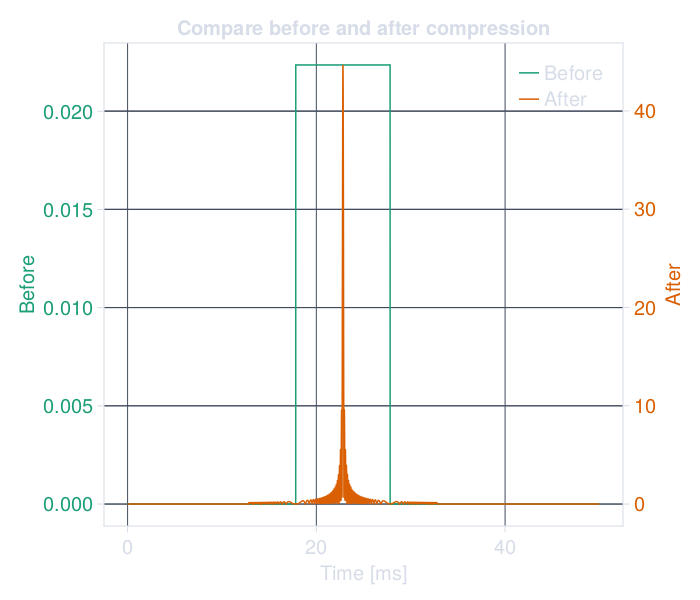

In [7]:
raw_signal = tdma_data[:,1,1]
match_signal = match_filter(raw_signal, S_up)

t = (0:length(raw_signal)-1)./fs .|> toUnit(u"ms")

F = Figure(backgroundcolor=bg, resolution=(700,600))
ax1 = Axis(F[1, 1], yticklabelcolor = cscheme[1], xlabel="Time [ms]", ylabel="Before", ylabelcolor=cscheme[1],
    title="Compare before and after compression")
ax2 = Axis(F[1, 1], yticklabelcolor = cscheme[2], yaxisposition = :right, ylabel="After", ylabelcolor=cscheme[2])
hidespines!(ax2)
hidexdecorations!(ax2)
l1 = lines!(ax1, t, abs.(raw_signal), color=cscheme[1])
l2 = lines!(ax2, t, abs.(match_signal), color=cscheme[2])
axislegend(ax1, [l1, l2], ["Before", "After"])

F

### Practical time-resolution

In [8]:
# Assumes only 1 peak
fwhm(x) = (count(a -> a >= 0.5maximum(x), x)+2) / fs

fwhm (generic function with 1 method)

τₚ = fwhm(P_match) |> toUnit(u"ms") = 0.1 ms


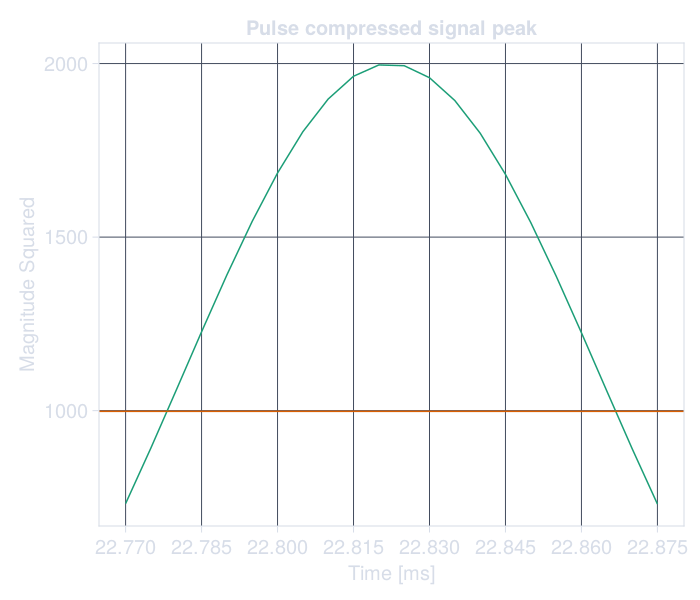

In [9]:
P_match = @. abs(match_signal)^2

@show τₚ = fwhm(P_match) |> toUnit(u"ms")

F = Figure(backgroundcolor = bg, resolution=(700,600))

mask = P_match .>= 0.35maximum(P_match)
ax = Axis(F[1,1], xlabel="Time [ms]", ylabel="Magnitude Squared", title="Pulse compressed signal peak", xticks=ustrip.(t[mask])[1:3:end])

lines!(t[mask], P_match[mask], label="Signal")
hlines!(0.5maximum(P_match), color=cscheme[2], label="FWHM")
F

# 2. Virtual Arrays

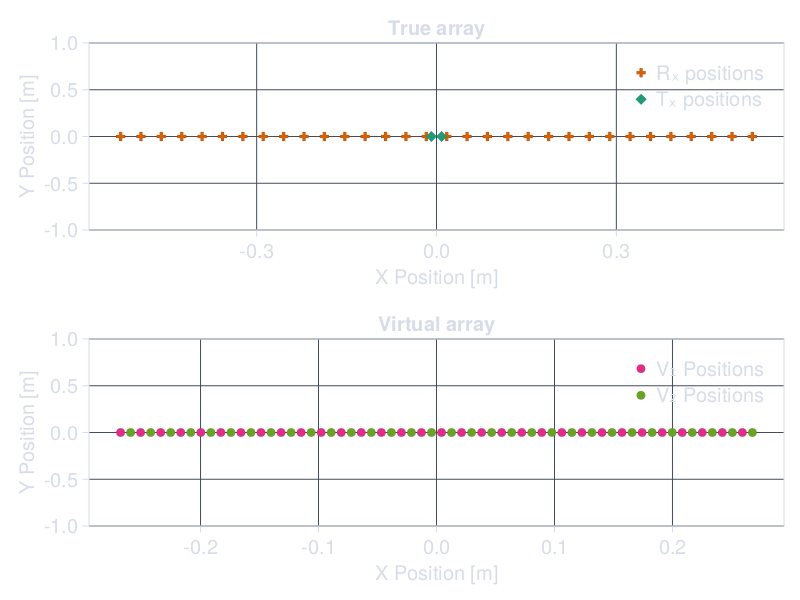

In [10]:
v_pos1 = map(x->(x+tₓ_pos[1]) / 2, rₓ_pos)
v_pos2 = map(x->(x+tₓ_pos[2]) / 2, rₓ_pos)
v_pos = sort([v_pos1; v_pos2])

F = Figure(backgroundcolor=bg, resolution=(800, 600))
ax1 = Axis(F[1,1], title="True array", xlabel="X Position [m]", ylabel="Y Position [m]")

scatter!(rₓ_pos, zeros(Nᵣₓ), marker=:cross, color=cscheme[2], label="Rₓ positions")
scatter!(tₓ_pos, zeros(Nₜₓ), marker=:diamond, color=cscheme[1], label="Tₓ positions")
axislegend(ax1)

ax2 = Axis(F[2,1], title="Virtual array", xlabel="X Position [m]", ylabel="Y Position [m]")
# linkxaxes!(ax1, ax2)
scatter!(v_pos1, zeros(Nᵣₓ), marker=:circle, color=cscheme[4], label="V₁ Positions")
scatter!(v_pos2, zeros(Nᵣₓ), marker=:circle, color=cscheme[5], label="V₂ Positions")
axislegend(ax2)
F

### Theoretical lateral resolution

In [11]:
λ = c/fc |> toUnit(m)
L₁ = v_pos1[end] - v_pos1[1]
Lₐ = v_pos[end] - v_pos[1]

@show δβ₁ = λ/2L₁;
@show δβₐ = λ/2Lₐ;

δβ₁ = λ / (2L₁) = 0.03225806451612903
δβₐ = λ / (2Lₐ) = 0.03174603174603175


### Approximate lateral resolution in meters at 4m

In [12]:
@show δβ₁_4m = δβ₁*4m;
@show δβₐ_4m = δβₐ*4m;

δβ₁_4m = δβ₁ * (4m) = 0.12903225806451613 m
δβₐ_4m = δβₐ * (4m) = 0.126984126984127 m


### Approximate axial pulse-echo resolution in meters

In [13]:
δr = c/2B |> toUnit(u"m");
@show δr;

δr = 0.017 m


# 3 Delay-And-Sum

In [14]:
Nₜ/fs |> toUnit(u"ms")

50.0 ms

In [15]:
@views function DAS(grid, channel_data, tx, rx)
    # Partial result allocation
    result = zeros(ComplexF64, size(grid))
    for k in eachindex(tx)
        for j in eachindex(rx)
            for i in CartesianIndices(grid)
                rᵣ = norm([rx[j], 0m] .- grid[i])
                rₜ = norm([tx[k], 0m] .- grid[i])
                τ = (rₜ+rᵣ)/c
                τ_sample = round(Int, τ * fs)
                result[i] += channel_data[τ_sample, j, k]
            end
        end
    end
    result
end;

In [16]:
X = (-5:δβₐ/10:5)m
Y =  0m:δr/5:5m
grid = [ [i,j] for i=X, j=Y ]
mfdata = mapslices(channel -> match_filter(channel, S_up), tdma_data, dims=(1,))

# result = DAS(grid, mfdata, tₓ_pos, rₓ_pos);
@show size(grid)
# amp_result = abs.(result)
# db_result = amp_result./maximum(amp_result) .|> amp2db;

size(grid) = (3150, 1471)


(3150, 1471)

In [17]:
# using BenchmarkTools
# @btime DAS(grid, mfdata, tₓ_pos, rₓ_pos);

In [18]:
function _das_kernel(p,tx,rx,data)
    rᵣ = norm([rx, 0m] .- p)
    rₜ = norm([tx, 0m] .- p)
    τ = (rₜ+rᵣ)/c
    τ_sample = round(Int, τ * fs)
    data[τ_sample]
end

function DAS_MT(grid, data, tx, rx)
    n_threads = Threads.nthreads()
    t_ids = 1:n_threads

    # Distribute receivers among channels
    n_rx = length(rx)

    #     |---Evenly divide---|  |------Fix Reminders--------|
    t_rx = @. n_rx ÷ n_threads + (t_ids <= (n_rx % n_threads))
    t_rx_offset = accumulate(+, [0; t_rx[1:end-1]])

    # Partial result allocation
    result = zeros(ComplexF64, (size(grid)..., n_threads))
    # t_id = 1
    Threads.@threads for t_id in t_ids
        rxs = rx[(1:t_rx[t_id]).+t_rx_offset[t_id]]
        t_results = @view result[:,:,t_id]

        for i_tx in eachindex(tx)
            for i_rx in eachindex(rxs)
                @simd for k in eachindex(grid)
                    p = grid[k]
                    t_results[k] += _das_kernel(p, tx[i_tx], rxs[i_rx], @view data[:,i_rx+t_rx_offset[t_id],i_tx])                    
                end
            end
        end
    end
    dropdims(sum(result, dims=(3,)), dims=3)
end;

In [35]:
results_mt = DAS_MT(grid, mfdata, tₓ_pos, rₓ_pos);

LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1mgetindex[22m
    [90m    @ [39m[90m./[39m[90m[4mtuple.jl:29[24m[39m[90m [inlined][39m
      [2] [0m[1miterate[22m
    [90m    @ [39m[90m./[39m[90m[4mtuple.jl:68[24m[39m[90m [inlined][39m
      [3] [0m[1mcopyto![22m[0m[1m([22m[90mdest[39m::[0mVector[90m{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}[39m, [90msrc[39m::[0mTuple[90m{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}, Quantity{Int64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}[39m[0m[1m)[22m
    [90m    @ [39m[90mBase[39m [90m./[39m[90m[4mabstractarray.jl:906[24m[39m
      [4] [0m[1mvect[22m[0m[1m([22m::[0mQuantity[90m{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}[39m, ::[0mVararg[90m{Any}[39m[0m[1m)[22m
    [90m    @ [39m[90mBase[39m [90m./[39m[90m[4marray.jl:147[24m[39m
      [5] [0m[1m_das_kernel[22m[0m[1m([22m[90mp[39m::[0mVector[90m{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}[39m, [90mtx[39m::[0mQuantity[90m{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}[39m, [90mrx[39m::[0mQuantity[90m{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}[39m, [90mdata[39m::[0mSubArray[90m{ComplexF64, 1, Array{ComplexF64, 3}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64, Int64}, true}[39m[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m./[39m[90m[4mIn[18]:2[24m[39m
      [6] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m./[39m[90m[4mIn[18]:31[24m[39m[90m [inlined][39m
      [7] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m./[39m[90m[4msimdloop.jl:77[24m[39m[90m [inlined][39m
      [8] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m./[39m[90m[4mIn[18]:29[24m[39m[90m [inlined][39m
      [9] [0m[1m(::var"#58#threadsfor_fun#18"{var"#58#threadsfor_fun#17#19"{Matrix{Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}}, Array{ComplexF64, 3}, Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}, Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}, Array{ComplexF64, 3}, Vector{Int64}, Vector{Int64}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m
     [10] [0m[1m#58#threadsfor_fun[22m
    [90m    @ [39m[90m./[39m[90m[4mthreadingconstructs.jl:51[24m[39m[90m [inlined][39m
     [11] [0m[1m(::Base.Threads.var"#1#2"{var"#58#threadsfor_fun#18"{var"#58#threadsfor_fun#17#19"{Matrix{Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}}, Array{ComplexF64, 3}, Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}, Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}, Array{ComplexF64, 3}, Vector{Int64}, Vector{Int64}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:30[24m[39m

In [ ]:
# @btime DAS_MT(grid, mfdata, tₓ_pos, rₓ_pos);

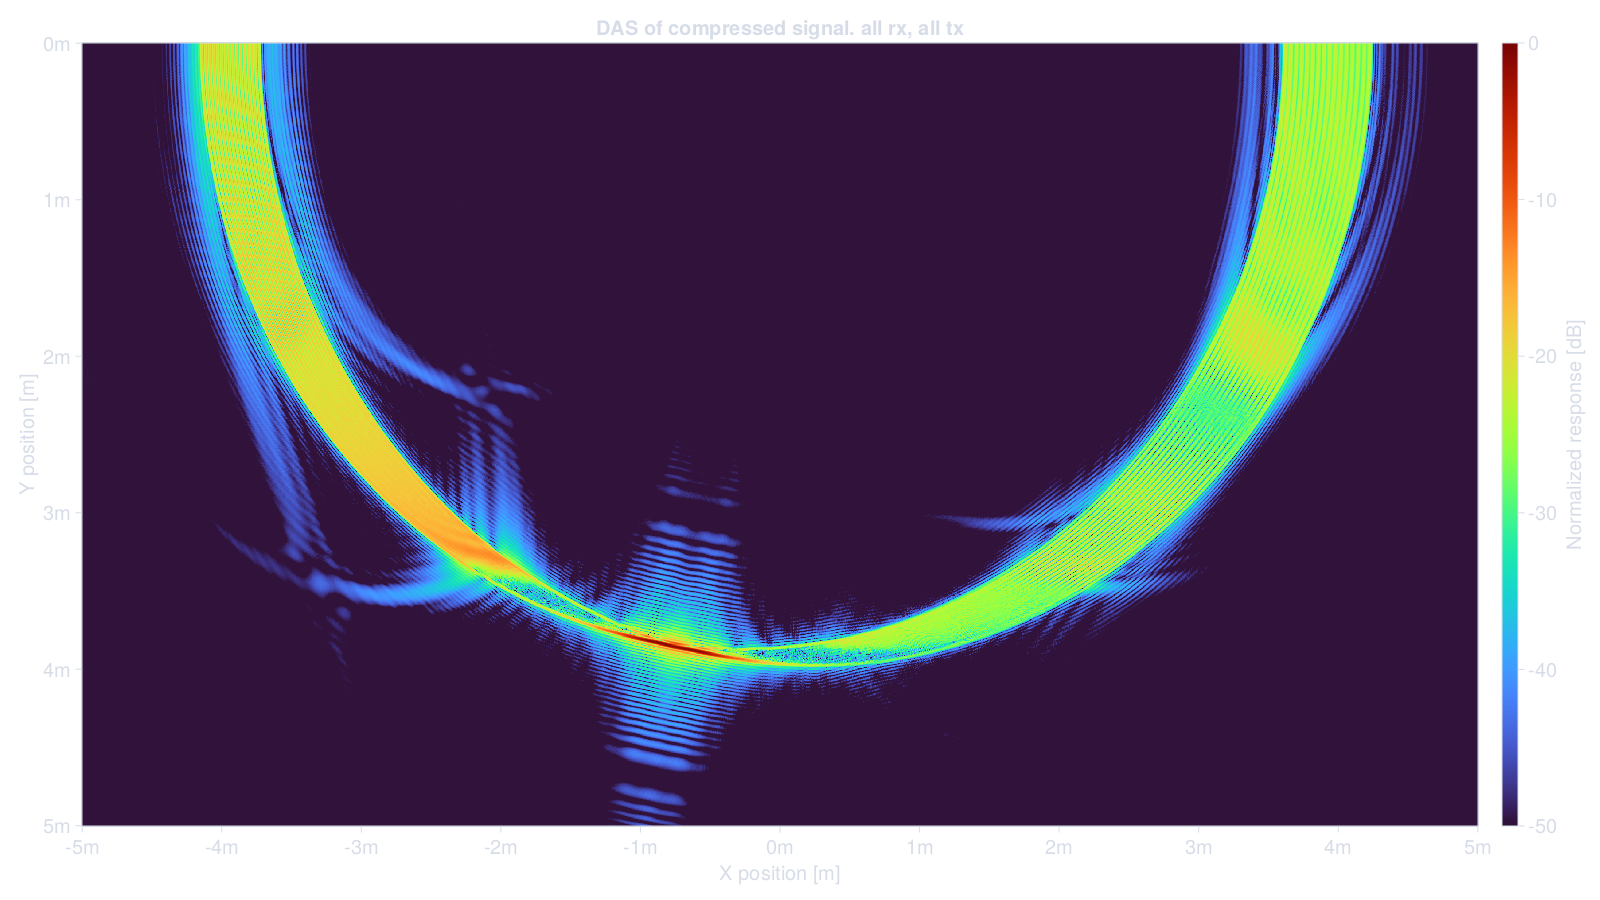

In [ ]:
amp_result = abs.(results_mt)
db_result = amp_result./maximum(amp_result) .|> amp2db;
xs = range(-5,5,size(db_result,1))
ys = range( 0,5,size(db_result,2))
F = Figure(backgroundcolor=bg, resolution=(1600, 900))
ax = Axis(
    F[1,1], 
    xlabel="X position [m]", ylabel="Y position [m]", 
    xticks=MultiplesTicks(11,1,"m"), yticks=MultiplesTicks(6, 1, "m"), 
    yreversed=true, 
    title="DAS of compressed signal. all rx, all tx"
)
clims = (-50, 0)
hm = heatmap!(ax, xs, ys, db_result, colorrange=clims, colormap=:turbo)
cb = Colorbar(F[1,2], hm, label="Normalized response [dB]")
F

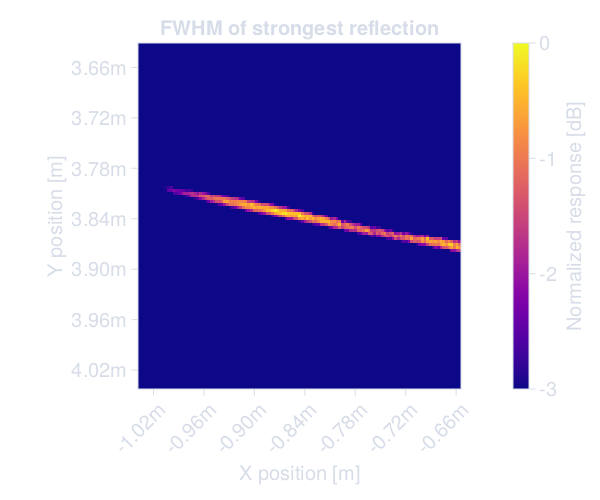

In [ ]:
R = argmax(db_result)
reg = CartesianIndex(20,20)
ROI = (R-reg):(R+reg)
F = Figure(backgroundcolor=bg, resolution=(600, 500))
ax = Axis(
    F[1,1], 
    xlabel="X position [m]", ylabel="Y position [m]", 
    xticks=MultiplesTicks(7,1,"m"), yticks=MultiplesTicks(7, 1, "m"), 
    yreversed=true, xticklabelrotation=pi/4, aspect=DataAspect(),
    title="FWHM of strongest reflection"
)
clims = (-3, 0)
hm = heatmap!(ax, xs[(-reg[1]:reg[1]).+R[1]], ys[(-reg[2]:reg[2]).+R[2]], db_result[ROI], colorrange=clims, colormap=:plasma)
cb = Colorbar(F[1,2], hm, label="Normalized response [dB]")
F

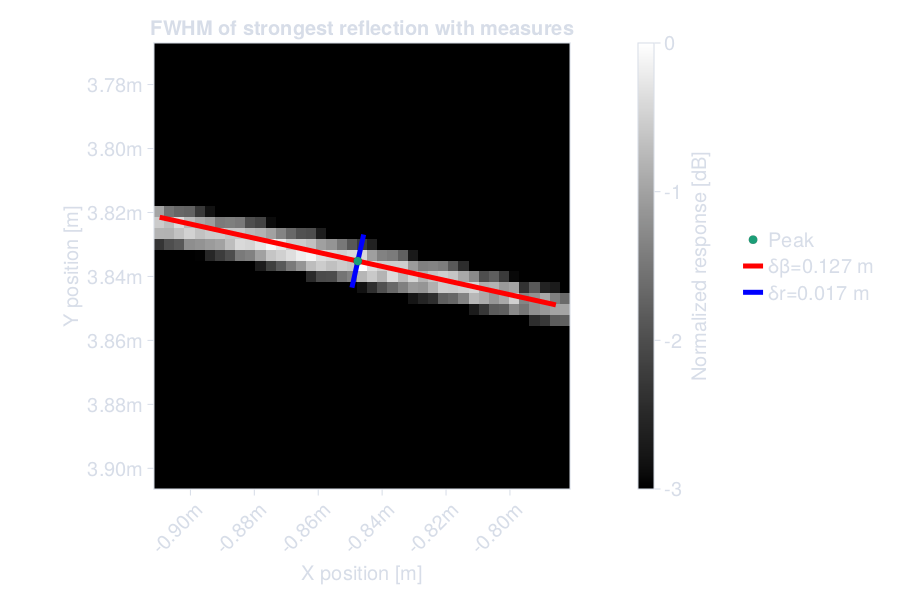

In [ ]:
# Calculate lateral & axial lines
p_max = grid[R]
d_a = p_max./norm(p_max)
d_l = [-d_a[2], d_a[1]]
δβ_line = [p_max.-d_l*δβₐ_4m/2 p_max.+d_l*δβₐ_4m/2]
δr_line = [p_max.-d_a*δr/2 p_max.+d_a*δr/2]

F = Figure(backgroundcolor=bg, resolution=(900, 600))
ax = Axis(
    F[1,1], 
    xlabel="X position [m]", ylabel="Y position [m]", 
    xticks=MultiplesTicks(7,1,"m"), yticks=MultiplesTicks(7, 1, "m"), 
    yreversed=true, xticklabelrotation=pi/4, aspect=DataAspect(),
    title="FWHM of strongest reflection with measures",
)
clims = (-3, 0)
hm = heatmap!(ax, xs[(-reg[1]:reg[1]).+R[1]], ys[(-reg[2]:reg[2]).+R[2]], db_result[ROI], colorrange=clims, colormap=:greys)
cb = Colorbar(F[1,2], hm, label="Normalized response [dB]")
lateral_l = lines!(ax, ustrip.(δβ_line) , linewidth=5, color=:red)
axial_l = lines!(ax, ustrip.(δr_line) , linewidth=5, color=:blue) 
max_point = scatter!(ax, ustrip(p_max)...)
Legend(F[1,3], [max_point, lateral_l, axial_l], ["Peak", "δβ=$(printx(ustrip(δβₐ_4m), 3)) m","δr=$(printx(ustrip(δr), 3)) m"])
F

### Single Tx Channel

In [ ]:
results_mt2 = DAS_MT(grid, mfdata, tₓ_pos[1], rₓ_pos);
amp_result2 = abs.(results_mt2)
db_result2 = amp_result2./maximum(amp_result2) .|> amp2db;

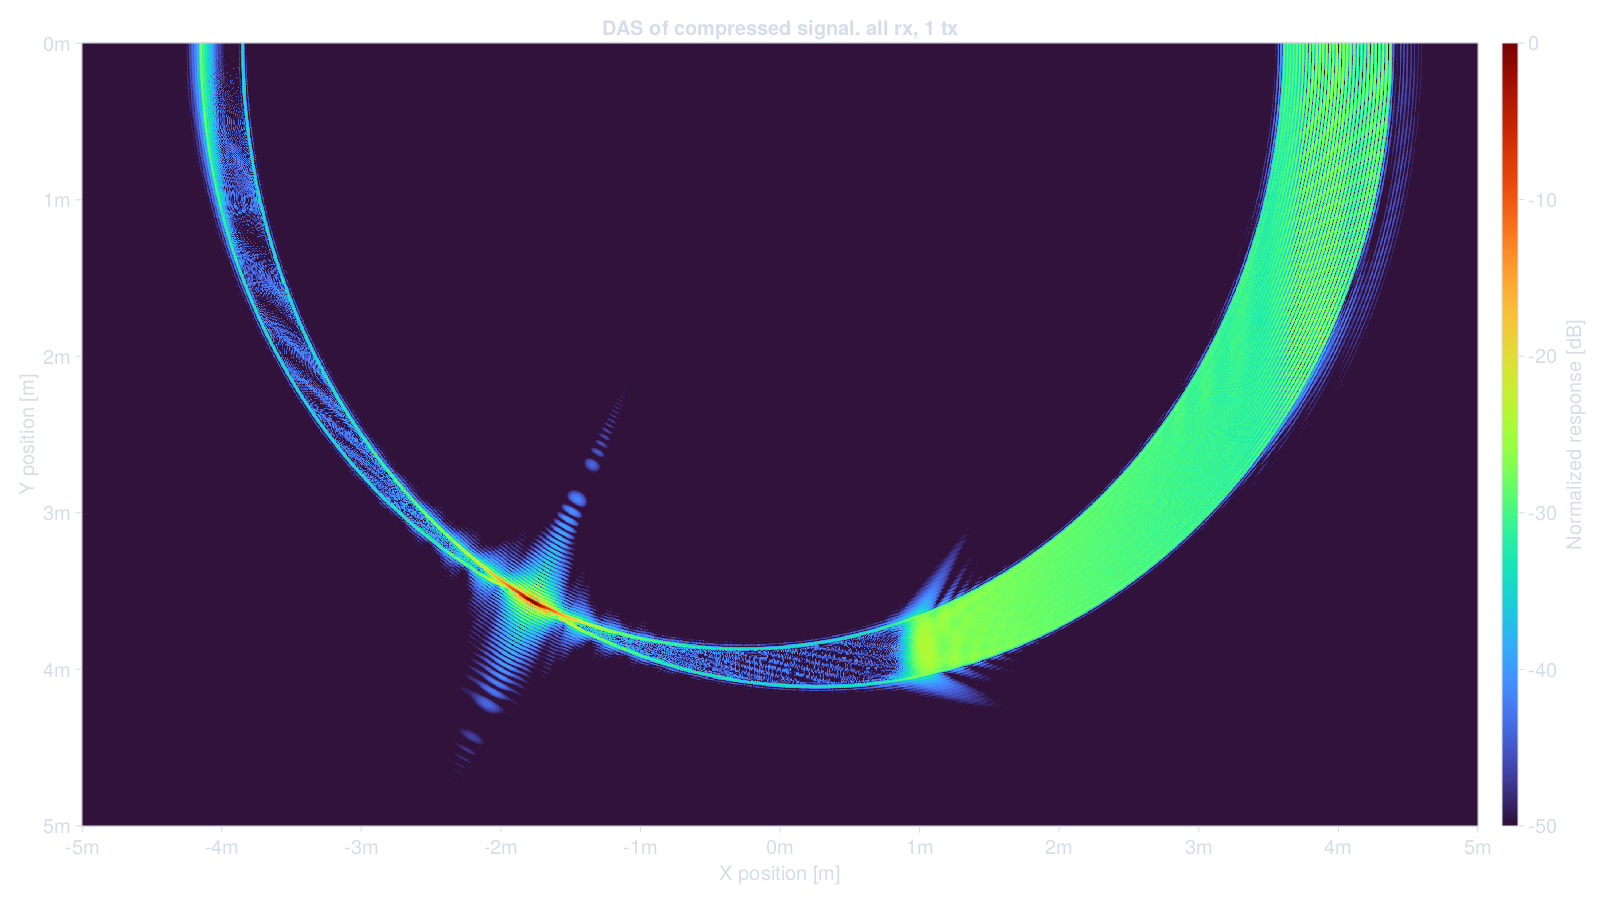

In [25]:
xs = range(-5,5,size(db_result2,1))
ys = range( 0,5,size(db_result2,2))
F = Figure(backgroundcolor=bg, resolution=(1600, 900))
ax = Axis(
    F[1,1], 
    xlabel="X position [m]", ylabel="Y position [m]", 
    xticks=MultiplesTicks(11,1,"m"), yticks=MultiplesTicks(6, 1, "m"), 
    yreversed=true, 
    title="DAS of compressed signal. all rx, 1 tx"
)
clims = (-50, 0)
hm = heatmap!(ax, xs, ys, db_result2, colorrange=clims, colormap=:turbo)
cb = Colorbar(F[1,2], hm, label="Normalized response [dB]")
F

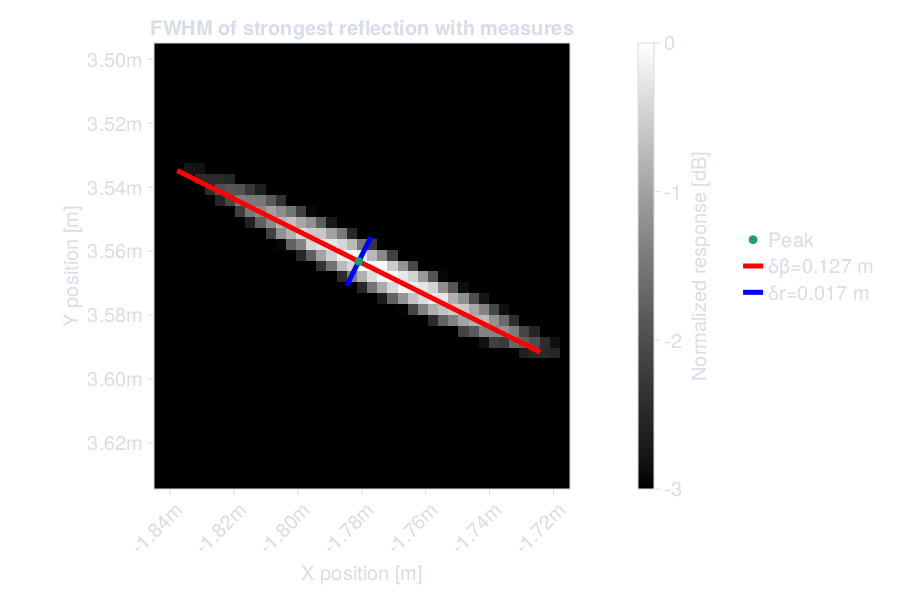

In [32]:
# Calculate lateral & axial lines
R = argmax(db_result2)
reg = CartesianIndex(20,20)
ROI = (R-reg):(R+reg)
p_max = grid[R]
d_a = p_max./norm(p_max)
d_l = [-d_a[2], d_a[1]]
δβ_line = [p_max.-d_l*δβₐ_4m/2 p_max.+d_l*δβₐ_4m/2]
δr_line = [p_max.-d_a*δr/2 p_max.+d_a*δr/2]

F = Figure(backgroundcolor=bg, resolution=(900, 600))
ax = Axis(
    F[1,1], 
    xlabel="X position [m]", ylabel="Y position [m]", 
    xticks=MultiplesTicks(7,1,"m"), yticks=MultiplesTicks(7, 1, "m"), 
    yreversed=true, xticklabelrotation=pi/4, aspect=DataAspect(),
    title="FWHM of strongest reflection with measures",
)
clims = (-3, 0)
hm = heatmap!(ax, xs[(-reg[1]:reg[1]).+R[1]], ys[(-reg[2]:reg[2]).+R[2]], db_result2[ROI], colorrange=clims, colormap=:greys)
cb = Colorbar(F[1,2], hm, label="Normalized response [dB]")
lateral_l = lines!(ax, ustrip.(δβ_line) , linewidth=5, color=:red)
axial_l = lines!(ax, ustrip.(δr_line) , linewidth=5, color=:blue) 
max_point = scatter!(ax, ustrip(p_max)...)
Legend(F[1,3], [max_point, lateral_l, axial_l], ["Peak", "δβ=$(printx(ustrip(δβₐ_4m), 3)) m","δr=$(printx(ustrip(δr), 3)) m"])
F

### Run on CDMA

In [27]:
# Create match filtered data from up/down chirps
mfdata2 = Array{ComplexF64,3}(undef, Nₜ, Nᵣₓ, Nₜₓ)
mfdata2[:,:,1] .= mapslices(channel -> match_filter(channel, S_down), cdma_data, dims=(1,))
mfdata2[:,:,2] .= mapslices(channel -> match_filter(channel, S_up), cdma_data, dims=(1,))

@show size(mfdata2);

size(mfdata2) = (10000, 32, 2)


In [28]:
results_mt3 = DAS_MT(grid, mfdata2, tₓ_pos, rₓ_pos);

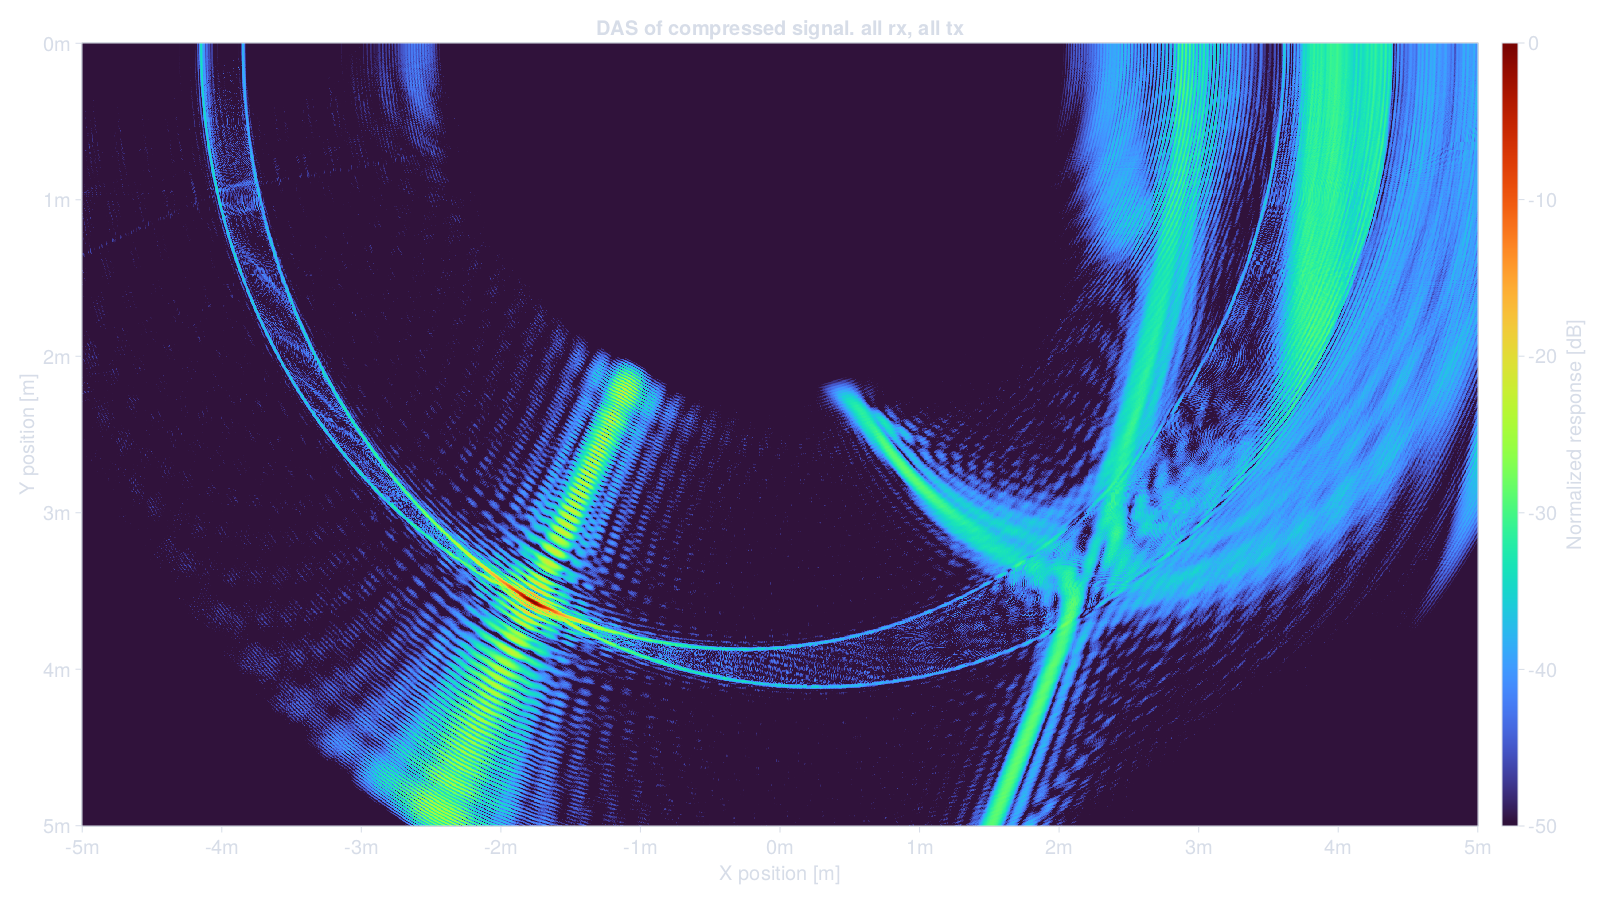

In [29]:
amp_result3 = abs.(results_mt3)
db_result3 = amp_result3./maximum(amp_result3) .|> amp2db;
xs = range(-5,5,size(db_result,1))
ys = range( 0,5,size(db_result,2))
F = Figure(backgroundcolor=bg, resolution=(1600, 900))
ax = Axis(
    F[1,1], 
    xlabel="X position [m]", ylabel="Y position [m]", 
    xticks=MultiplesTicks(11,1,"m"), yticks=MultiplesTicks(6, 1, "m"), 
    yreversed=true, 
    title="DAS of compressed signal. all rx, all tx"
)
clims = (-50, 0)
hm = heatmap!(ax, xs, ys, db_result3, colorrange=clims, colormap=:turbo)
cb = Colorbar(F[1,2], hm, label="Normalized response [dB]")
F

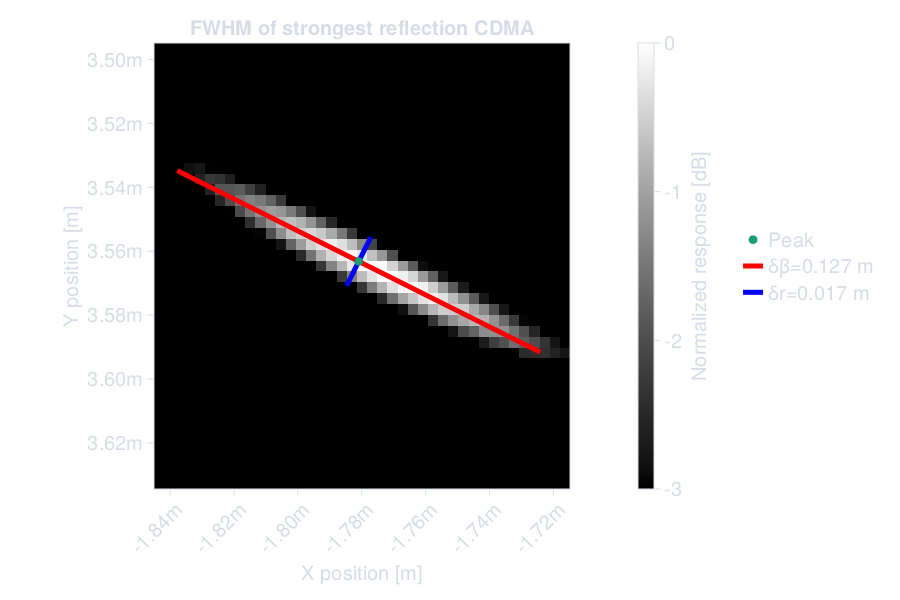

In [31]:
# Calculate lateral & axial lines
R = argmax(db_result3)
reg = CartesianIndex(20,20)
ROI = (R-reg):(R+reg)
p_max = grid[R]
d_a = p_max./norm(p_max)
d_l = [-d_a[2], d_a[1]]
δβ_line = [p_max.-d_l*δβₐ_4m/2 p_max.+d_l*δβₐ_4m/2]
δr_line = [p_max.-d_a*δr/2 p_max.+d_a*δr/2]

F = Figure(backgroundcolor=bg, resolution=(900, 600))
ax = Axis(
    F[1,1], 
    xlabel="X position [m]", ylabel="Y position [m]", 
    xticks=MultiplesTicks(7,1,"m"), yticks=MultiplesTicks(7, 1, "m"), 
    yreversed=true, xticklabelrotation=pi/4, aspect=DataAspect(),
    title="FWHM of strongest reflection CDMA",
)
clims = (-3, 0)
hm = heatmap!(ax, xs[(-reg[1]:reg[1]).+R[1]], ys[(-reg[2]:reg[2]).+R[2]], db_result3[ROI], colorrange=clims, colormap=:greys)
cb = Colorbar(F[1,2], hm, label="Normalized response [dB]")
lateral_l = lines!(ax, ustrip.(δβ_line) , linewidth=5, color=:red)
axial_l = lines!(ax, ustrip.(δr_line) , linewidth=5, color=:blue) 
max_point = scatter!(ax, ustrip(p_max)...)
Legend(F[1,3], [max_point, lateral_l, axial_l], ["Peak", "δβ=$(printx(ustrip(δβₐ_4m), 3)) m","δr=$(printx(ustrip(δr), 3)) m"])
F